In [1]:
!pip install mxnet-cu100

#MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

mx.random.seed(1)

ctx = mx.gpu()

In [0]:
def transform(data, label):
    return data.reshape((784)).astype('float32')/255.0

train_mnist = gluon.data.vision.MNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.MNIST(train = False, transform = transform)

In [4]:
image = train_mnist[-1]
print(image.shape)

(784,)


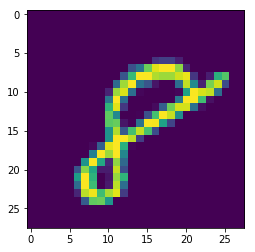

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy())
plt.show()

##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True, last_batch = 'rollover')
testing_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False, last_batch = 'rollover')

##Building the model

In [0]:
class vae(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(vae, self).__init__(**kwargs)
        self.encoder = nn.HybridSequential()
        self.encoder.add(nn.Dense(512, 'relu'))
        self.encoder.add(nn.Dense(512, 'relu'))       
        
        self.mu = nn.Dense(10)
        self.var = nn.Dense(10)
        
        self.decoder = nn.HybridSequential()
        self.decoder.add(nn.Dense(512, 'relu'))
        self.decoder.add(nn.Dense(512, 'relu'))
        self.decoder.add(nn.Dense(784, 'sigmoid'))
    
    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        
        mu = self.mu(h)
        var = self.var(h)
        
        z = mu + (F.broadcast_mul(F.exp(0.5 * var), F.random.normal(0, 1, (batch_size, 10))))
        
        y = self.decoder(z)
        
        self.output = y
        
        kl = 0.5 * F.sum((1 + var) - (mu * mu) - F.exp(var), axis = 1)
        logloss = F.sum((x * F.log(y + 1e-8)) + ((1 - x) * F.log(1 - (y + 1e-8))), axis = 1)
        
        loss = - logloss - kl
        return loss        

In [0]:
model = vae()
model.initialize(mx.init.Xavier(), ctx)
model.hybridize()

In [0]:
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.0001})

In [10]:
epochs = 20

for epoch in range(epochs):
    for features in training_data:
        cum_loss = 0.0
        with autograd.record():
            loss = model(features.as_in_context(ctx))
        loss.backward()
        trainer.step(batch_size)
        cum_loss += nd.mean(loss)
    print(f'Epoch: {epoch}, Loss: {cum_loss.asscalar():.5f}')

Epoch: 0, Loss: 155.96939
Epoch: 1, Loss: 137.76724
Epoch: 2, Loss: 132.29094
Epoch: 3, Loss: 118.46906
Epoch: 4, Loss: 124.06380
Epoch: 5, Loss: 117.14452
Epoch: 6, Loss: 125.25655
Epoch: 7, Loss: 118.35210
Epoch: 8, Loss: 113.46534
Epoch: 9, Loss: 108.06914
Epoch: 10, Loss: 116.70638
Epoch: 11, Loss: 108.54382
Epoch: 12, Loss: 110.49914
Epoch: 13, Loss: 110.92963
Epoch: 14, Loss: 113.48236
Epoch: 15, Loss: 107.84094
Epoch: 16, Loss: 103.55298
Epoch: 17, Loss: 106.59082
Epoch: 18, Loss: 98.00677
Epoch: 19, Loss: 107.20001


In [0]:
model.save_parameters('vae.params')

In [0]:
model = vae()
model.load_parameters('vae.params', ctx)

In [21]:
for features in testing_data:
    model(features.as_in_context(ctx))
    generated = model.output
    break
generated.shape

(64, 784)

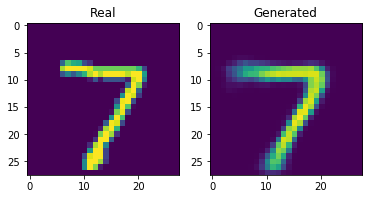

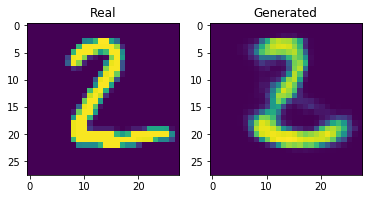

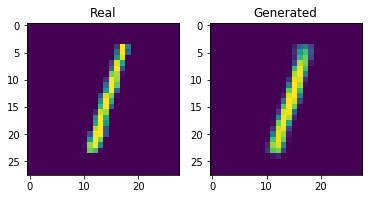

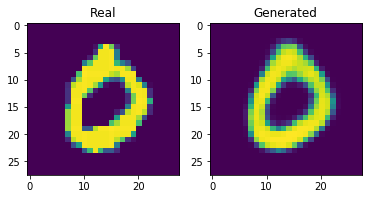

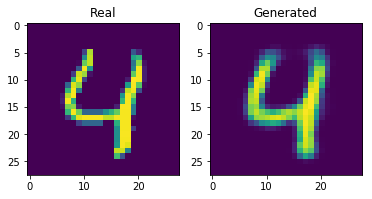

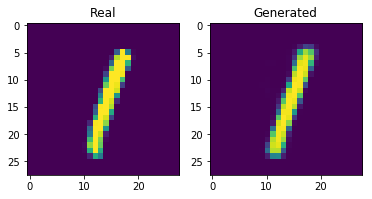

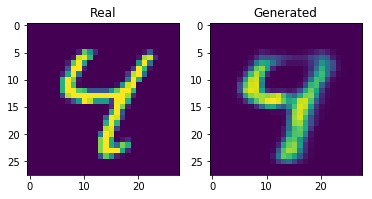

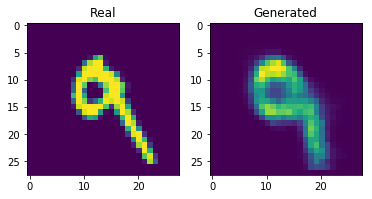

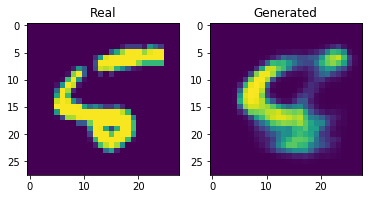

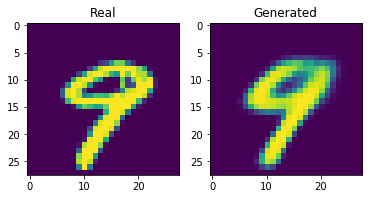

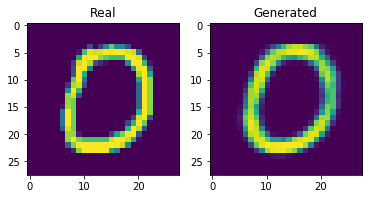

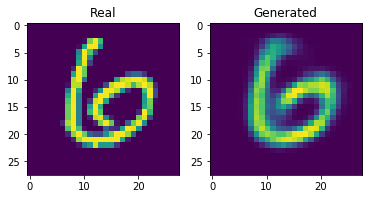

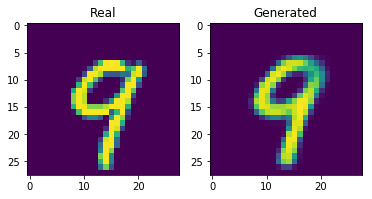

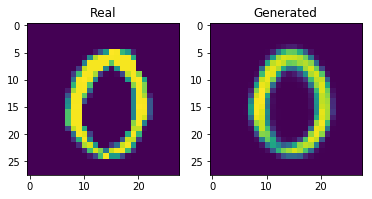

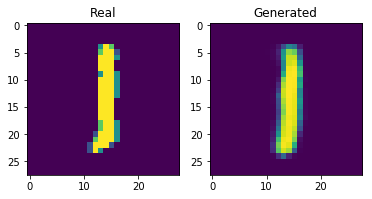

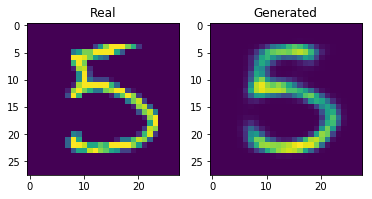

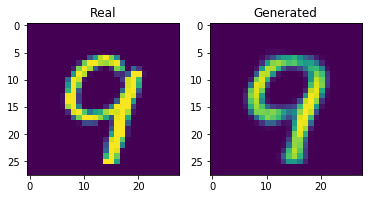

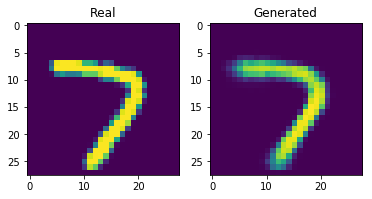

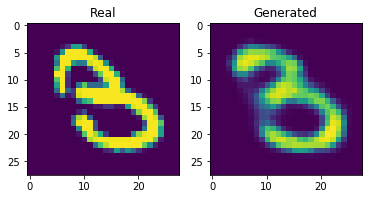

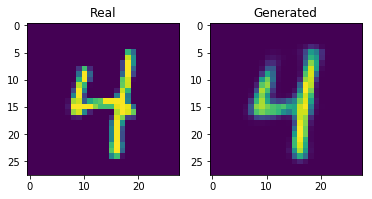

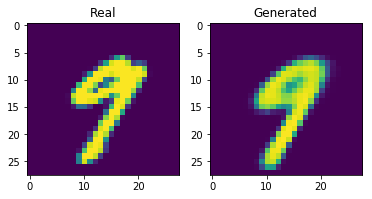

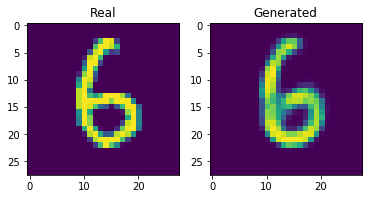

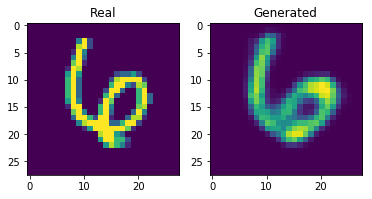

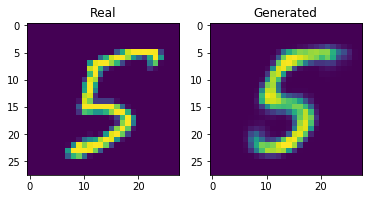

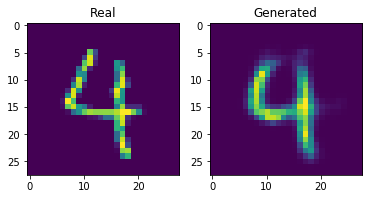

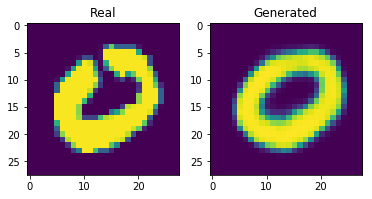

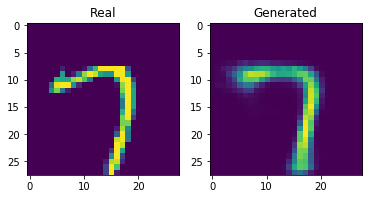

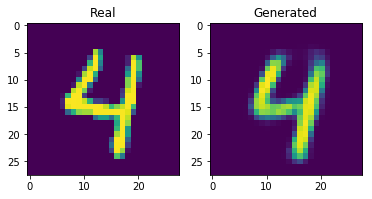

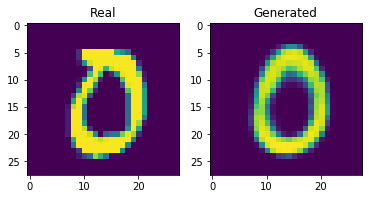

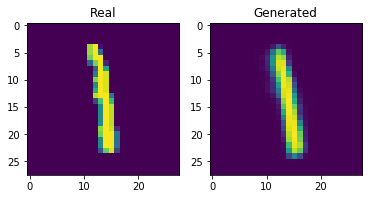

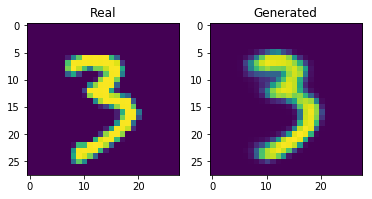

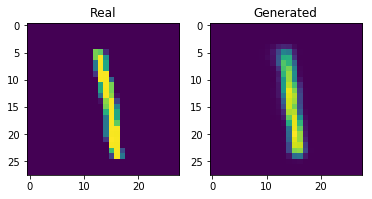

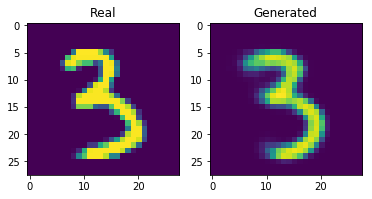

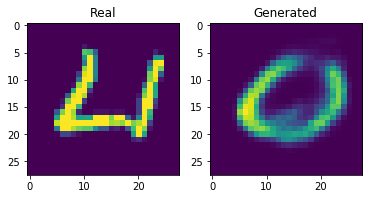

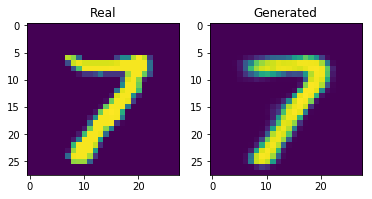

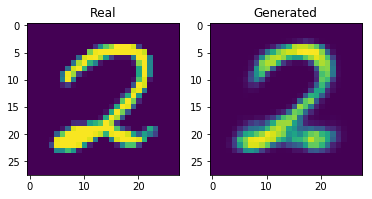

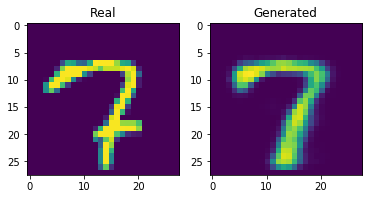

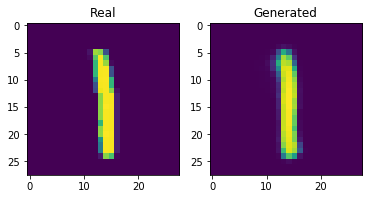

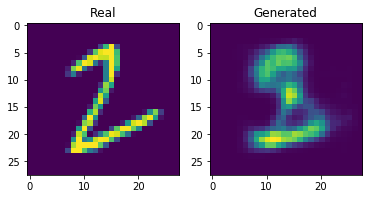

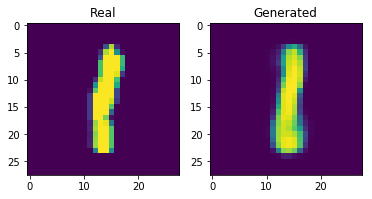

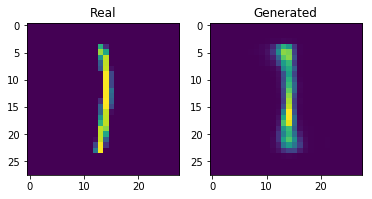

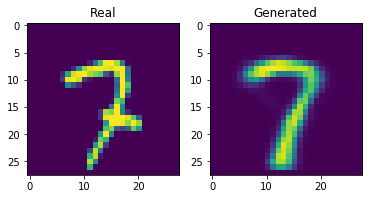

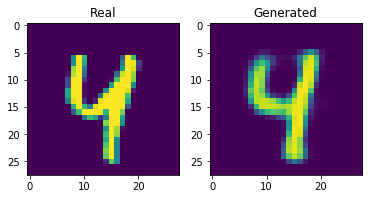

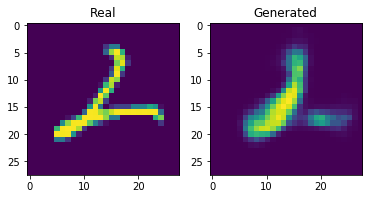

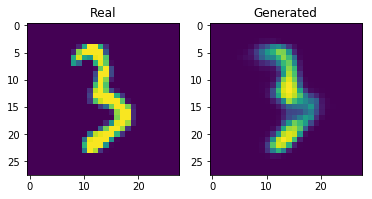

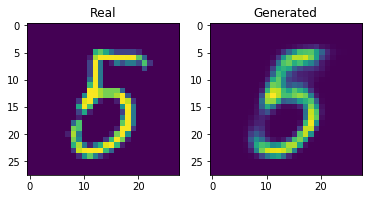

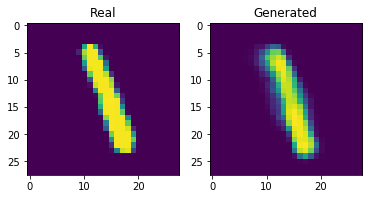

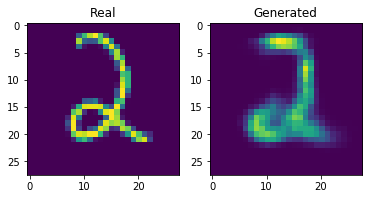

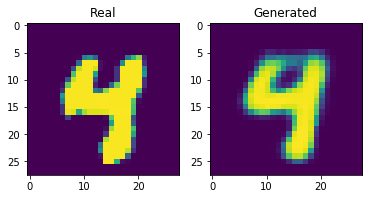

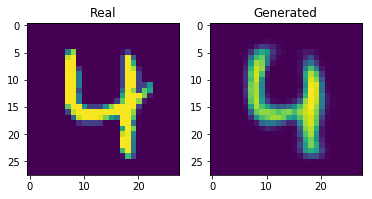

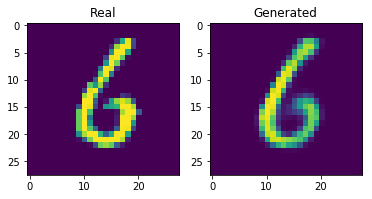

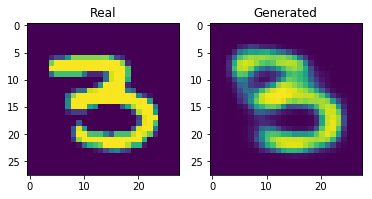

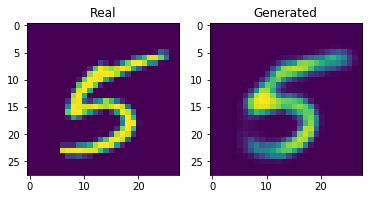

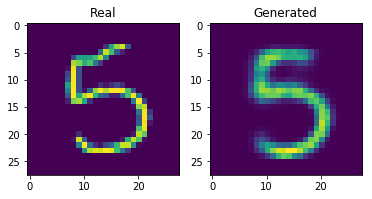

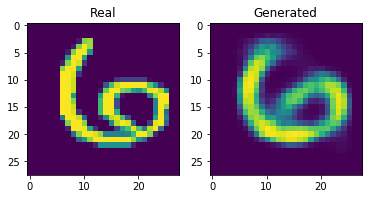

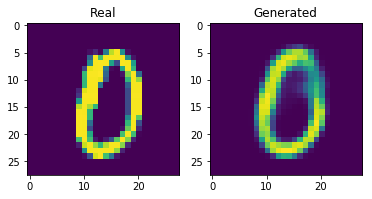

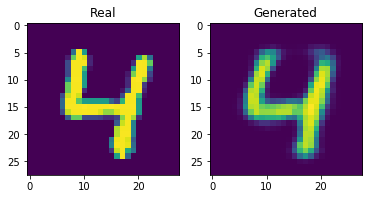

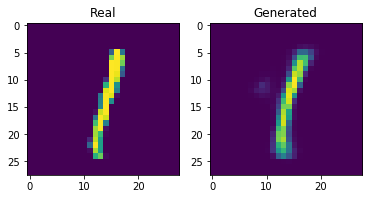

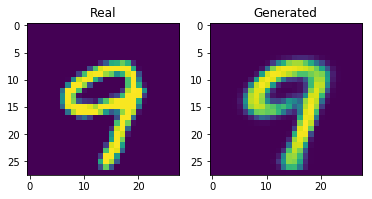

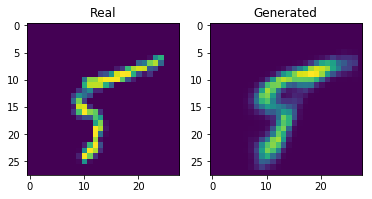

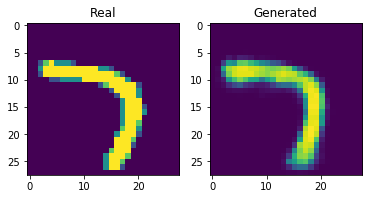

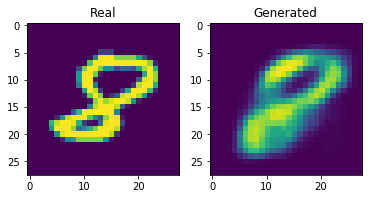

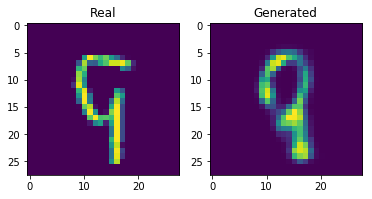

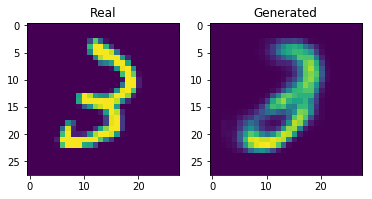

In [22]:
for i in range(batch_size):
    plt.subplot(1, 2, 1)
    plt.imshow(features[i].reshape((28, 28)).asnumpy())
    plt.title('Real')
    
    plt.subplot(1, 2, 2)
    plt.imshow(generated[i].reshape((28, 28)).asnumpy())
    plt.title('Generated')
    plt.show()